In [1]:
import numpy as np
# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
np.random.seed(42)
import sys
%matplotlib inline  

In [2]:
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_sample
from astropy.table import Table
from astropy.timeseries import LombScargle
from astroML.time_series import MultiTermFit

In [3]:
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)
# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
cmap = mcolors.ListedColormap(colors)

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


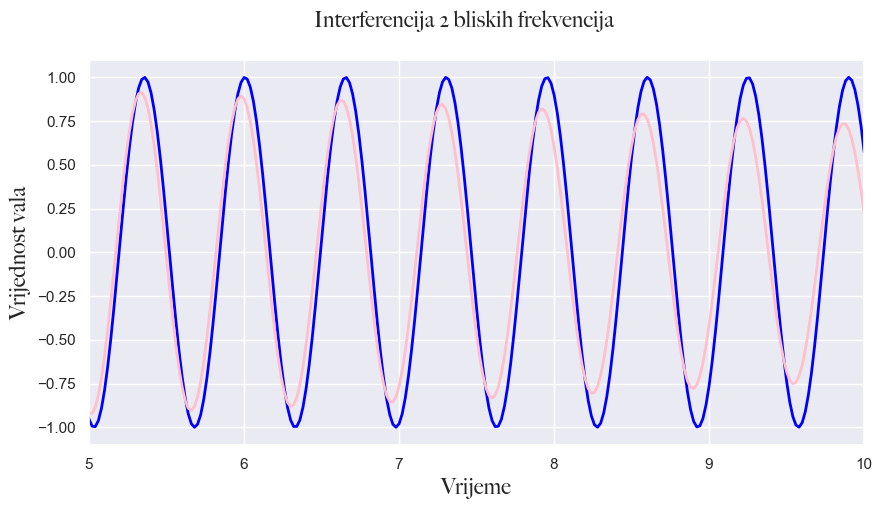

In [4]:
# SIMULATED DATA
Ngrid = 5000  
Tmax = 100     # we generate light curve for times going from 0 to 100 days
maxmagerr = 0.3
# ----
time = np.linspace(0, Tmax, Ngrid)

fn = 1.54 # normal frequency
fblazhko = 1.57 # blazhko frequency
Ablazhko = 0.3 # blazhko amplitude

lcn = np.sin(2*time*fn*3.1415926) # standard light curve data - no modulation 
lc_blazhko = np.sin(2*3.1415926*fblazhko*time)*Ablazhko + lcn # inference beats with the blazhko frequency
lc_blazhko = lc_blazhko/np.max(lc_blazhko) # normalizing to 1 magnitude so scale stays the same

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c="blue", lw=2)
plt.plot(time,lc_blazhko,c="pink", lw=2)
plt.xlabel("Vrijeme", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(5,10)
plt.savefig("../images/interpolation.png", dpi=650)
plt.show()

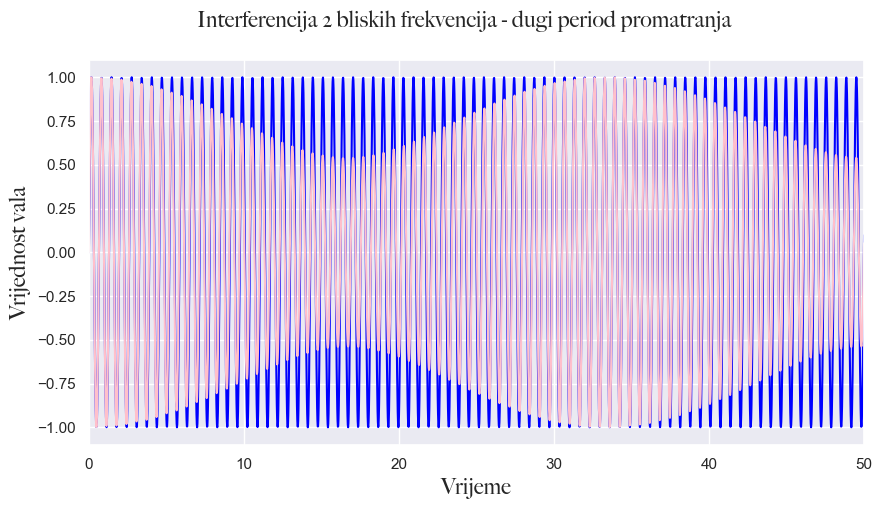

In [5]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija - dugi period promatranja", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c="blue")
plt.plot(time,lc_blazhko,c="pink")
plt.xlabel("Vrijeme", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(0,50)
plt.savefig("../images/interpolation2.png", dpi=650)
plt.show()

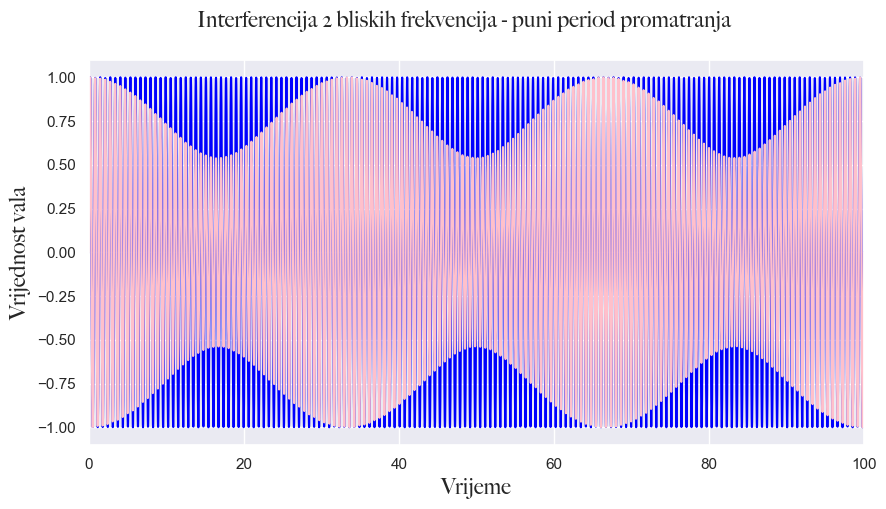

In [6]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija - puni period promatranja", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c="blue")
plt.plot(time,lc_blazhko,c="pink")
plt.xlabel("Vrijeme", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(0,100)
plt.savefig("../images/interpolation3.png", dpi=650)
plt.show()

---

In [7]:
import random

In [8]:
# SIMULATING LIGHT CURVE
Ngrid = 10000
Tmax = 100

fmain = 1.54
fbl = 1.57

Time = np.linspace(0, Tmax, Ngrid)
lcmain = np.sin(2*3.1415926*Time*fmain)
lc = 2*np.cos(2*3.1415926*Time*(fbl - fmain))*lcmain
lc = lc/np.max(lc)

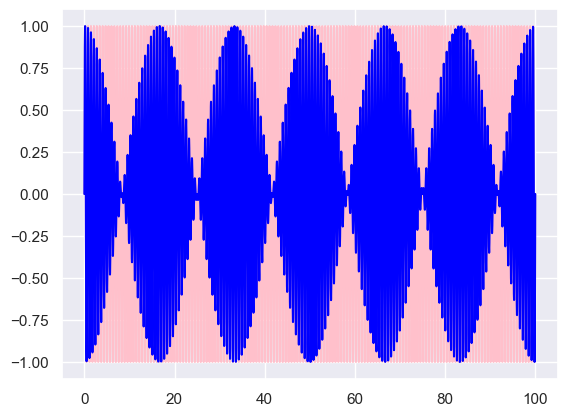

In [9]:
plt.plot(Time, lcmain, c='pink')
plt.plot(Time, lc, c='blue')
plt.show()

In [26]:
# SIMULATING OBSERVATION DATA

Ndata = 400
magErr = 0.1
Ablazhko = 0.5
time_data = Tmax * np.random.random(Ndata)

#lcdata = 2*np.cos(2*3.1415926*time_data*(fblazhko-fmain))*np.sin(2*3.1415926*time_data*((fmain+fblazhko)/2))
lcdata = np.sin(2*3.1415926*time_data*fmain) + Ablazhko*np.sin(2*3.1415926*time_data*fblazhko) + Ablazhko*np.sin(2*3.1415926*time_data*(2*fmain-fblazhko))
lcdata = lcdata/np.max(lcdata)
magErrObs = magErr + 0*time_data
LCbObsErr = lcdata + np.random.normal(0, magErrObs)

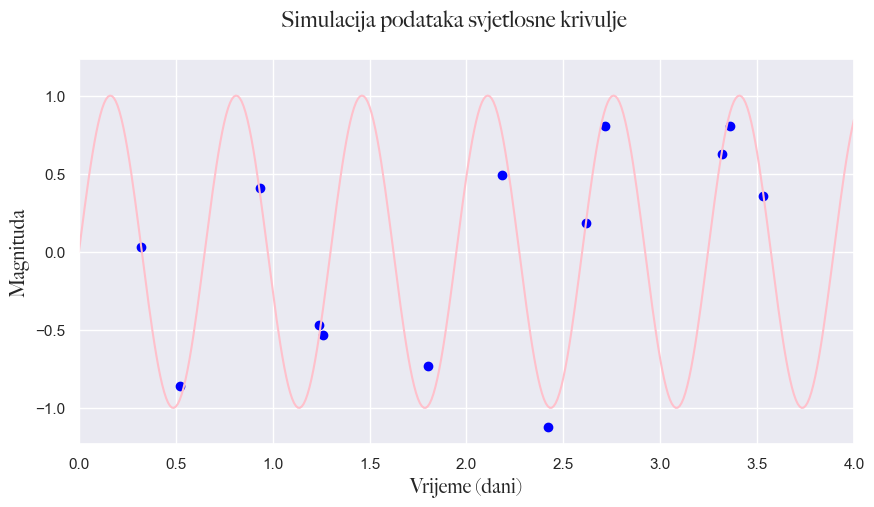

In [27]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Simulacija podataka svjetlosne krivulje", fontproperties=font,fontsize=16)
plt.plot(Time, lcmain, c='pink')
plt.scatter(time_data, LCbObsErr, c='blue')
plt.xlabel('Vrijeme (dani)',fontproperties=font,fontsize=14)
plt.ylabel('Magnituda', fontproperties=font,fontsize=14)
plt.xlim(0,4)
plt.savefig('../images/lc_dataeg.png', dpi=650)
plt.show()

In [28]:
def doPeriods(time, mag, magErr, nterms, lsPS=True, nyquist=100, freqFac=1.05, verbose=True):
    try:
        if verbose:print('Starting calculations...')
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        #frequencyAuto, powerAuto = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        #best_freq = frequencyAuto[np.argmax(powerAuto)]
        # frequency = np.arange(best_freq/freqFac, best_freq*freqFac, 5e-6)
        frequency = np.arange(1.0, 2.0, 5e-5)
        if verbose: print('Arranging frequencies to calculate...')
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        if verbose: print('Possible periods determined')
        # hack: limit around known frequency to avoid aliases
        powerRestricted = power[(frequency>1.3)&(frequency>1.7)]
        #freqRestricted = frequency[(frequency>1.3)&(frequency>1.7)]
        #periodRestricted = 1. / freqRestricted
        best_period = period[np.argmax(powerRestricted)] # choosing the period with the highest power
        if verbose: print("Best period is ", best_period)
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        return 'Error in doPeriods'

In [29]:
period, freq, power = doPeriods(time_data, LCbObsErr, magErrObs, nterms=3)

Starting calculations...
Arranging frequencies to calculate...
Possible periods determined
Best period is  0.8755417414522938


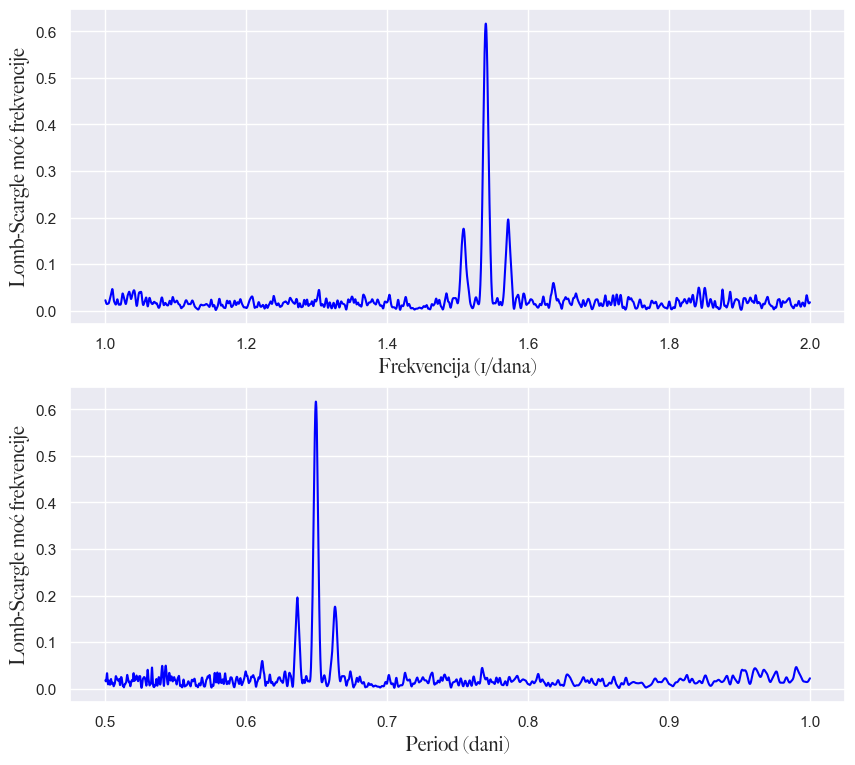

In [30]:
# PLOTTING PERIODOGRAM:
fig = plt.figure(figsize=(10, 9))

ax = fig.add_subplot(211)
ax.plot(freq, power, c='blue')
#ax.set_xlim(1.9,2.0)
ax.set_ylabel('Lomb-Scargle moć frekvencije', fontproperties=font,fontsize=14)
ax.set_xlabel('Frekvencija (1/dana)', fontproperties=font,fontsize=14)

ax = fig.add_subplot(212)
ax.plot(1/freq, power, c='blue')
#ax.set_xlim(0.5,1.0)
ax.set_ylabel('Lomb-Scargle moć frekvencije', fontproperties=font,fontsize=14)
ax.set_xlabel('Period (dani)', fontproperties=font,fontsize=14)
plt.savefig("../images/periodogrameg.png",dpi=650)
plt.show()